In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from bayesiankalman import mcmc
from scipy import stats
import laplacejumps as lj
import itertools
import sklearn.preprocessing as skprocess
from sklearn.metrics import explained_variance_score
from sklearn import neighbors, ensemble
import statsmodels.api as sm
from statsmodels.tsa import api as tsa
from pandas_datareader import data as pd_data
from sklearn import metrics

In [5]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')
presentation_fontsize=22
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})

In [9]:
with pd.HDFStore('../results/spy_daily_estimates_2003-2017.tmp.hdf') as volatility_store:
    discrete_vol = volatility_store['discrete_vol_est']
    
discrete_vol['quad'] = discrete_vol['jumps'] + discrete_vol['diffusion']
log_vol = discrete_vol.transform(np.log).dropna()

In [10]:
daily_rtn_data = pd.read_csv('../results/spy_daily_rtn_2003-2017_with_overnight.csv', index_col=0,
                         parse_dates=True).rename(columns={'log_price':'daily_rtn'}).daily_rtn
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})
daily_rtn = 252 * (daily_rtn_data - treasury_yield.T).T.rename(columns={'log_yield':'daily_rtn'}).dropna()

In [11]:
fed_announcement_dates = pd.read_hdf('../results/fomc_times.hdf', 'table')
dates = pd.DataFrame(np.ones((fed_announcement_dates.size,1)), 
                     index=fed_announcement_dates['FOMC_times']).resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})

In [12]:
percentiles = np.asarray([50, 90, 99])
jump_prop_percentiles = np.asarray([50])

## Compute Jump proportions at various percentiles

In [13]:
jump_prop = (discrete_vol['jumps'] / discrete_vol['quad']).dropna().to_frame().rename(columns={0:'jump_prop'})

In [14]:
jump_prop.mean()

jump_prop    0.2251
dtype: float64

In [15]:
jump_prop.jump_prop.autocorr()

0.39534662439274154

## Jump Proportion Summary Statistics

In [16]:
pd.concat((discrete_vol['quad'].dropna().apply(np.log), jump_prop), axis=1).corr()

quad  jump_prop
quad       1.0000     0.3589
jump_prop  0.3589     1.0000

In [17]:
stats.spearmanr(discrete_vol['quad'].dropna(), jump_prop.dropna())

SpearmanrResult(correlation=0.48219625531320764, pvalue=1.522679773420856e-215)

In [18]:
jump_prop.describe()

jump_prop
count  3713.0000
mean      0.2251
std       0.0213
min       0.0499
25%       0.2132
50%       0.2279
75%       0.2392
max       0.3499

In [19]:
combined_data = pd.concat([dates.resample('D').last().fillna(0).rename(columns={0:'fomc_dates'}), 
                           discrete_vol['quad'].apply(np.log), daily_rtn,
                           jump_prop, treasury_yield], axis=1).dropna()

In [20]:
daily_rtn.mean()

daily_rtn    0.0382
dtype: float64

In [21]:
combined_data.corr()

fomc_dates    quad  daily_rtn  jump_prop  log_yield
fomc_dates      1.0000  0.0782     0.0536     0.0107     0.0057
quad            0.0782  1.0000    -0.1518     0.3542     0.0964
daily_rtn       0.0536 -0.1518     1.0000    -0.0665    -0.0046
jump_prop       0.0107  0.3542    -0.0665     1.0000     0.2110
log_yield       0.0057  0.0964    -0.0046     0.2110     1.0000

In [22]:
combined_data.describe()

fomc_dates       quad  daily_rtn  jump_prop   log_yield
count   3678.0000  3678.0000  3678.0000  3678.0000  3.6780e+03
mean       0.0313    -9.8288     0.0380     0.2252  8.7963e-05
std        0.1741     1.0039     2.8543     0.0213  2.8860e-05
min        0.0000   -12.8143   -24.2947     0.0499  3.7534e-05
25%        0.0000   -10.5128    -1.0834     0.2133  6.1368e-05
50%        0.0000    -9.9646     0.1322     0.2280  8.7941e-05
75%        0.0000    -9.2590     1.3457     0.2393  1.1424e-04
max        1.0000    -4.7535    25.5391     0.3499  1.4410e-04

In [23]:
jump_prop_model = sm.WLS.from_formula('daily_rtn ~ jump_prop', weight=combined_data['quad'].apply(np.exp), 
                                      data=combined_data).fit()
jump_prop_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.004     
Dependent Variable: daily_rtn        AIC:                18139.7032
Date:               2018-09-05 15:06 BIC:                18152.1235
No. Observations:   3678             Log-Likelihood:     -9067.9   
Df Model:           1                F-statistic:        16.33     
Df Residuals:       3676             Prob (F-statistic): 5.44e-05  
R-squared:          0.004            Scale:              8.1135    
--------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025    0.975]
--------------------------------------------------------------------
Intercept       2.0441    0.4987   4.0987  0.0000    1.0663   3.0218
jump_prop      -8.9065    2.2043  -4.0405  0.0001  -13.2283  -4.5847
-------------------------------------------------------------------
Omnibus:              798.828      Durbin-Watson:         2.177    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      14504.279
Skew:                 -0.545       Prob(JB):              0.000    
Kurtosis:             12.667       Condition No.:         49       
===================================================================

"""

## Nonlinear Analaysis

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from patsy import dmatrix

In [26]:
eqn = '(jump_prop + np.square(jump_prop)) * (quad + np.square(quad))'

In [27]:
jump_prop_x = np.linspace(0,1,100)
quad_x = np.linspace(-10, -6, 100)
umm_data = pd.DataFrame(np.asarray(np.meshgrid(jump_prop_x,quad_x)).T.reshape(-1,2), 
                        columns=['quad', 'jump_prop']).transform(lambda x: x - x.mean())
X = dmatrix(eqn, data=umm_data)

In [28]:
rtn_on_quad_and_jumps = sm.WLS.from_formula('daily_rtn ~ ' + eqn, weights=combined_data.quad.apply(np.exp),
                                            data=combined_data.transform(lambda x: x - x.mean())).fit()

In [29]:
rtn_on_quad_and_jumps.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Weighted least squares
=========================================================================================
Model:                      WLS                     Adj. R-squared:            0.020     
Dependent Variable:         daily_rtn               AIC:                       26556.1094
Date:                       2018-09-05 15:06        BIC:                       26612.0006
No. Observations:           3678                    Log-Likelihood:            -13269.   
Df Model:                   8                       F-statistic:               10.39     
Df Residuals:               3669                    Prob (F-statistic):        1.73e-14  
R-squared:                  0.022                   Scale:                     0.0043014 
-----------------------------------------------------------------------------------------
                                       Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
-----------------------------------------------------------------------------------------
Intercept                              -0.1028   0.1816 -0.5662 0.5713   -0.4588   0.2532
jump_prop                              -6.1741   9.5018 -0.6498 0.5159  -24.8035  12.4552
np.square(jump_prop)                  167.3135 221.2123  0.7563 0.4495 -266.3978 601.0248
quad                                   -0.4675   0.1945 -2.4033 0.0163   -0.8489  -0.0861
np.square(quad)                         0.0583   0.0572  1.0187 0.3084   -0.0539   0.1705
jump_prop:quad                          6.6459  12.0811  0.5501 0.5823  -17.0404  30.3323
jump_prop:np.square(quad)               2.2126   3.6914  0.5994 0.5489   -5.0247   9.4499
np.square(jump_prop):quad            -139.4088 244.1517 -0.5710 0.5680 -618.0952 339.2776
np.square(jump_prop):np.square(quad)   39.8325  65.4953  0.6082 0.5431  -88.5783 168.2434
-----------------------------------------------------------------------------------------
Omnibus:                   2052.773             Durbin-Watson:                2.333      
Prob(Omnibus):             0.000                Jarque-Bera (JB):             1389638.611
Skew:                      1.254                Prob(JB):                     0.000      
Kurtosis:                  98.192               Condition No.:                24209      
=========================================================================================
* The condition number is large (2e+04). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [30]:
explained_variance_score(y_pred=rtn_on_quad_and_jumps.fittedvalues, 
                         y_true=stats.zscore(combined_data.daily_rtn))

-0.5115789610949151

In [31]:
combined_data.quantile(.01)

fomc_dates    0.0000e+00
quad         -1.1726e+01
daily_rtn    -8.7000e+00
jump_prop     1.6559e-01
log_yield     4.1917e-05
Name: 0.01, dtype: float64

In [32]:
combined_data.describe()

fomc_dates       quad  daily_rtn  jump_prop   log_yield
count   3678.0000  3678.0000  3678.0000  3678.0000  3.6780e+03
mean       0.0313    -9.8288     0.0380     0.2252  8.7963e-05
std        0.1741     1.0039     2.8543     0.0213  2.8860e-05
min        0.0000   -12.8143   -24.2947     0.0499  3.7534e-05
25%        0.0000   -10.5128    -1.0834     0.2133  6.1368e-05
50%        0.0000    -9.9646     0.1322     0.2280  8.7941e-05
75%        0.0000    -9.2590     1.3457     0.2393  1.1424e-04
max        1.0000    -4.7535    25.5391     0.3499  1.4410e-04

In [33]:
eqn2 = "-1 + bs(jump_prop, df=6, include_intercept=False)"
jump_prob_bs_model = sm.WLS.from_formula("daily_rtn ~ " + eqn2, weights=combined_data.quad.apply(np.exp),
                                   data=combined_data.transform(lambda x: x - x.mean())).fit()

In [34]:
jump_prob_bs_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Weighted least squares
================================================================================================
Model:                         WLS                       Adj. R-squared:              0.032     
Dependent Variable:            daily_rtn                 AIC:                         26566.2985
Date:                          2018-09-05 15:06          BIC:                         26603.5592
No. Observations:              3678                      Log-Likelihood:              -13277.   
Df Model:                      6                         F-statistic:                 21.08     
Df Residuals:                  3672                      Prob (F-statistic):          1.92e-24  
R-squared:                     0.033                     Scale:                       0.0043168 
------------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------------------------------------
bs(jump_prop, df=6, include_intercept=False)[0] 10.6261   4.3488  2.4434 0.0146   2.0997 19.1524
bs(jump_prop, df=6, include_intercept=False)[1] -8.4769   1.2777 -6.6345 0.0000 -10.9820 -5.9718
bs(jump_prop, df=6, include_intercept=False)[2]  0.7293   0.2901  2.5139 0.0120   0.1605  1.2980
bs(jump_prop, df=6, include_intercept=False)[3] -4.0981   1.1506 -3.5618 0.0004  -6.3539 -1.8423
bs(jump_prop, df=6, include_intercept=False)[4] 11.1942   4.3865  2.5520 0.0108   2.5940 19.7945
bs(jump_prop, df=6, include_intercept=False)[5] -2.2534   2.7181 -0.8290 0.4071  -7.5824  3.0757
------------------------------------------------------------------------------------------------
Omnibus:                      1599.842               Durbin-Watson:                  2.302      
Prob(Omnibus):                0.000                  Jarque-Bera (JB):               1262250.954
Skew:                         0.558                  Prob(JB):                       0.000      
Kurtosis:                     93.749                 Condition No.:                  36         
================================================================================================

"""

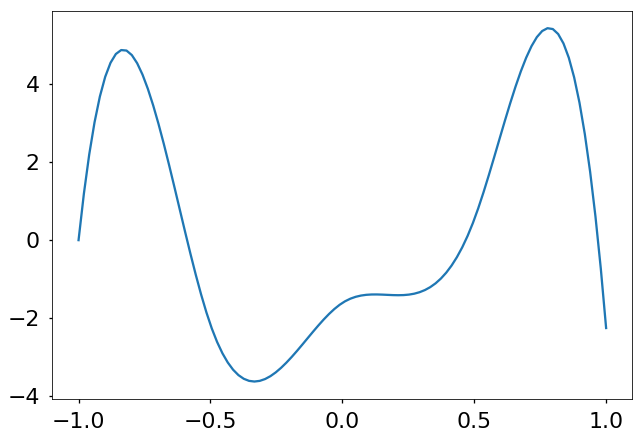

In [35]:
x = pd.DataFrame(np.linspace(-1,1, 100), columns=['jump_prop']) 
y = np.asarray(dmatrix(eqn2, data=x)).dot(jump_prob_bs_model.params)
mpl.pyplot.plot(x,y)

In [36]:
eqn3 = "-1 + bs(quad, df=6, include_intercept=False)"
quad_bs_model = sm.WLS.from_formula("daily_rtn ~ " + eqn2, combined_data,
                                   weights=combined_data['quad'].apply(np.exp)).fit()

In [37]:
quad_bs_model.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                Results: Weighted least squares
================================================================================================
Model:                         WLS                       Adj. R-squared:              0.030     
Dependent Variable:            daily_rtn                 AIC:                         26566.3041
Date:                          2018-09-05 15:07          BIC:                         26603.5649
No. Observations:              3678                      Log-Likelihood:              -13277.   
Df Model:                      6                         F-statistic:                 20.17     
Df Residuals:                  3672                      Prob (F-statistic):          2.48e-23  
R-squared:                     0.032                     Scale:                       0.0043168 
------------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------------------------------------
bs(jump_prop, df=6, include_intercept=False)[0] 10.6813   4.3488  2.4561 0.0141   2.1549 19.2077
bs(jump_prop, df=6, include_intercept=False)[1] -8.4426   1.2777 -6.6076 0.0000 -10.9476 -5.9375
bs(jump_prop, df=6, include_intercept=False)[2]  0.7677   0.2901  2.6465 0.0082   0.1990  1.3365
bs(jump_prop, df=6, include_intercept=False)[3] -4.0614   1.1506 -3.5299 0.0004  -6.3172 -1.8056
bs(jump_prop, df=6, include_intercept=False)[4] 11.2352   4.3865  2.5613 0.0105   2.6349 19.8354
bs(jump_prop, df=6, include_intercept=False)[5] -2.2162   2.7181 -0.8154 0.4149  -7.5452  3.1129
------------------------------------------------------------------------------------------------
Omnibus:                      1599.896               Durbin-Watson:                  2.302      
Prob(Omnibus):                0.000                  Jarque-Bera (JB):               1262251.434
Skew:                         0.558                  Prob(JB):                       0.000      
Kurtosis:                     93.749                 Condition No.:                  36         
================================================================================================

"""

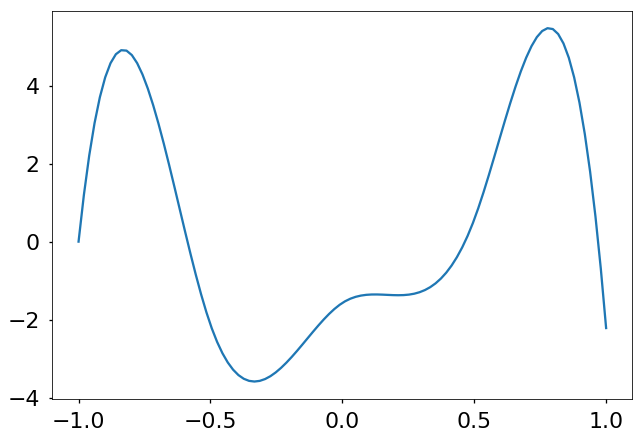

In [38]:
x = pd.DataFrame(np.linspace(-1,1, 100), columns=['quad']) 
y = np.asarray(dmatrix(eqn3, x)).dot(quad_bs_model.params)
mpl.pyplot.plot(x,y)

In [39]:
def tensor_prod_exog_mat(x1, x2, df=3):
    return np.asarray(dmatrix("1 + te(bs(x1,df=df), bs(x2,df=df))", {'x1':x1.ravel(), 
                                                    'x2':x2.ravel(), 'df':df}))

In [40]:
tensor_product_model = sm.WLS(endog=combined_data['daily_rtn'], 
                              exog=tensor_prod_exog_mat(combined_data.quad - combined_data.quad.mean(),
                                                        combined_data.jump_prop - combined_data.jump_prop.mean()),
                                  ).fit()

In [41]:
tensor_product_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Weighted least squares
===================================================================
Model:              WLS              Adj. R-squared:     0.032     
Dependent Variable: daily_rtn        AIC:                18044.6089
Date:               2018-09-05 15:07 BIC:                18106.7101
No. Observations:   3678             Log-Likelihood:     -9012.3   
Df Model:           9                F-statistic:        14.36     
Df Residuals:       3668             Prob (F-statistic): 4.53e-23  
R-squared:          0.034            Scale:              7.8892    
---------------------------------------------------------------------
          Coef.     Std.Err.      t      P>|t|     [0.025     0.975] 
---------------------------------------------------------------------
const     -0.5839     0.7500   -0.7786   0.4363    -2.0545     0.8866
x1        14.3608    11.3335    1.2671   0.2052    -7.8597    36.5814
x2       -19.7967    14.9214   -1.3267   0.1847   -49.0518     9.4584
x3        38.6381    19.0418    2.0291   0.0425     1.3046    75.9716
x4        19.9506    15.6566    1.2743   0.2026   -10.7458    50.6471
x5        -5.1481    23.8737   -0.2156   0.8293   -51.9551    41.6588
x6       -40.4809    29.1849   -1.3870   0.1655   -97.7012    16.7394
x7       -44.9329    17.4792   -2.5706   0.0102   -79.2029   -10.6629
x8        21.7651    25.2849    0.8608   0.3894   -27.8088    71.3390
x9        38.8134    30.9902    1.2524   0.2105   -21.9464    99.5732
-------------------------------------------------------------------
Omnibus:              657.756      Durbin-Watson:         2.204    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      13467.812
Skew:                 0.228        Prob(JB):              0.000    
Kurtosis:             12.363       Condition No.:         1357     
===================================================================
* The condition number is large (1e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

In [42]:
combined_data.daily_rtn.to_frame().quantile([.25, .5, .75])

daily_rtn
0.25    -1.0834
0.50     0.1322
0.75     1.3457

In [43]:
combined_data.head()

fomc_dates    quad  daily_rtn  jump_prop  log_yield
2003-01-03         0.0 -8.9089    -0.1317     0.2668     0.0001
2003-01-06         0.0 -9.2734     5.4954     0.2277     0.0001
2003-01-07         0.0 -8.7902    -1.5315     0.2625     0.0001
2003-01-08         0.0 -8.9947    -3.7850     0.2413     0.0001
2003-01-09         0.0 -9.1706     4.8963     0.2101     0.0001

In [44]:
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(list(combinations(xs,n)) for n in range(len(xs)+1))

    

In [45]:
def column_iterator(x1,x2, max_degree=2):
    
    data = np.column_stack([x1, x2])    
    poly_transform = skprocess.PolynomialFeatures(max_degree, include_bias=True)    
    return_data = poly_transform.fit_transform(data - np.mean(data))
    
    for indices in powerset(np.arange(1, 2**max_degree)):
        index_arr = np.array([0] + list(indices))
        yield index_arr, return_data[:, index_arr]
    

In [46]:
def get_minimum_ic(endog, x1,x2, degree=3, weights=None):
    ic = []
    for indices, exog in column_iterator(x1, x2, max_degree=degree):
        if weights is None:
            model = sm.OLS(endog=endog, exog=exog).fit()
        else: 
            model = sm.WLS(endog=endog, exog=exog, weights=weights).fit()
        ic.append((indices, model.bic))
    
    ic_vals = [val for _, val in ic]
    
    return ic[np.argmin(ic_vals)]
    
    

In [47]:
contour_plot_data = combined_data.copy()
contour_plot_data['quad'] = discrete_vol.quad.transform(np.sqrt)
contour_plot_data.daily_rtn = combined_data.daily_rtn
contour_plot_data['diffusion'] = discrete_vol.quad.transform(np.sqrt)
contour_plot_data['jumps'] = discrete_vol.quad.transform(np.sqrt)
indices, _ = get_minimum_ic(contour_plot_data.daily_rtn, contour_plot_data.quad, 
                            contour_plot_data.jump_prop, degree=3, weights=contour_plot_data.quad**2)

In [48]:
contour_plot_data.head()

fomc_dates    quad  daily_rtn  jump_prop  log_yield  diffusion  \
2003-01-03         0.0  0.0116    -0.1317     0.2668     0.0001     0.0116   
2003-01-06         0.0  0.0097     5.4954     0.2277     0.0001     0.0097   
2003-01-07         0.0  0.0123    -1.5315     0.2625     0.0001     0.0123   
2003-01-08         0.0  0.0111    -3.7850     0.2413     0.0001     0.0111   
2003-01-09         0.0  0.0102     4.8963     0.2101     0.0001     0.0102   

             jumps  
2003-01-03  0.0116  
2003-01-06  0.0097  
2003-01-07  0.0123  
2003-01-08  0.0111  
2003-01-09  0.0102

In [49]:
 poly_transform = skprocess.PolynomialFeatures(3, include_bias=True).fit(np.ones((4,2))).powers_[indices]

In [50]:
poly_transform

array([[0, 0],
       [1, 0],
       [0, 1],
       [1, 1],
       [3, 0],
       [2, 1]])

In [51]:
indices

array([0, 1, 2, 4, 6, 7])

In [52]:
def poly_regressors(x1, x2,indices, max_degree=2):
    
    data = data = np.column_stack([x1, x2])    
    poly_transform = skprocess.PolynomialFeatures(max_degree, include_bias=True) 
    return_data = poly_transform.fit_transform(data)

    return return_data[:, indices]

In [53]:
contour_plot_data.jump_prop.head()

2003-01-03    0.2668
2003-01-06    0.2277
2003-01-07    0.2625
2003-01-08    0.2413
2003-01-09    0.2101
Name: jump_prop, dtype: float64

In [54]:
poly_regressors(contour_plot_data.quad, contour_plot_data.jump_prop, indices, 3)

array([[1.0000e+00, 1.1627e-02, 2.6678e-01, 3.1018e-03, 1.5718e-06,
        3.6064e-05],
       [1.0000e+00, 9.6896e-03, 2.2773e-01, 2.2066e-03, 9.0974e-07,
        2.1382e-05],
       [1.0000e+00, 1.2338e-02, 2.6255e-01, 3.2393e-03, 1.8781e-06,
        3.9967e-05],
       ...,
       [1.0000e+00, 2.3673e-03, 1.8142e-01, 4.2947e-04, 1.3267e-08,
        1.0167e-06],
       [1.0000e+00, 2.4684e-03, 1.8891e-01, 4.6631e-04, 1.5040e-08,
        1.1510e-06],
       [1.0000e+00, 3.9251e-03, 2.3181e-01, 9.0989e-04, 6.0470e-08,
        3.5714e-06]])

In [55]:
# contour_plot_data = combined_data
# contour_plot_data.quad = discrete_vol.quad.transform(np.sqrt)
# contour_plot_data.daily_rtn = combined_data.daily_rtn 
n_levels = 6
# non_fomc_data = contour_plot_data
contour_plot_model = sm.OLS(endog=contour_plot_data.daily_rtn, 
                              exog=poly_regressors(contour_plot_data.quad, contour_plot_data.jump_prop, indices, 3)).fit()
levels = combined_data.daily_rtn.quantile(np.linspace(0,1,n_levels))
X, Y = np.meshgrid(np.linspace(contour_plot_data.quad.min(), contour_plot_data.quad.max(), 100), 
                    np.linspace(contour_plot_data.jump_prop.min(),contour_plot_data.jump_prop.max(),100))
Z = contour_plot_model.predict(exog=poly_regressors(X.ravel(), Y.ravel(), indices, 3)).reshape((100,100))


In [56]:
contour_plot_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.025     
Dependent Variable: daily_rtn        AIC:                18064.6789
Date:               2018-09-05 15:07 BIC:                18101.9396
No. Observations:   3678             Log-Likelihood:     -9026.3   
Df Model:           5                F-statistic:        20.10     
Df Residuals:       3672             Prob (F-statistic): 7.79e-20  
R-squared:          0.027            Scale:              7.9410    
-------------------------------------------------------------------
          Coef.     Std.Err.     t    P>|t|     [0.025     0.975]  
-------------------------------------------------------------------
const       2.8527     0.8508  3.3528 0.0008      1.1845     4.5209
x1       -199.7251    77.8621 -2.5651 0.0104   -352.3824   -47.0679
x2         -8.8837     4.1701 -2.1303 0.0332    -17.0598    -0.7077
x3        367.8649   378.0472  0.9731 0.3306   -373.3384  1109.0681
x4      -7833.5262 14730.6959 -0.5318 0.5949 -36714.6793 21047.6270
x5       8081.1532  7554.3147  1.0697 0.2848  -6729.9135 22892.2199
-------------------------------------------------------------------
Omnibus:              658.672      Durbin-Watson:         2.200    
Prob(Omnibus):        0.000        Jarque-Bera (JB):      13545.275
Skew:                 0.227        Prob(JB):              0.000    
Kurtosis:             12.390       Condition No.:         363247   
===================================================================
* The condition number is large (4e+05). This might indicate
strong multicollinearity or other numerical problems.
"""

In [57]:
np.mean(contour_plot_model.predict(exog=poly_regressors(combined_data.quad, combined_data.jump_prop, indices, 3)))

7842263.808978182

In [58]:
contour_plot_model.fittedvalues.mean()

0.0379857139866106

In [59]:
predicted_values = contour_plot_model.predict(exog=poly_regressors(combined_data.quad, 
                                                                   combined_data.jump_prop, indices, 3))

In [60]:
combined_data.query('fomc_dates==0').daily_rtn.mean()

0.010480692446058544

In [61]:
predicted_values.mean()

7842263.808978182

In [62]:
combined_data.query('fomc_dates==0').daily_rtn.mean()

0.010480692446058544

In [63]:
combined_data.daily_rtn.mean()

0.03798571398668367

In [64]:
predicted_excess_rtn = predicted_values -  combined_data.daily_rtn.mean()
overall_excess_rtn = announcement_data.daily_rtn - combined_data.daily_rtn.mean()

NameError: name 'announcement_data' is not defined

In [65]:
1 - (np.mean((predicted_values.mean() - announcement_data.daily_rtn.mean())**2) 
 / np.mean((announcement_data.daily_rtn.mean() - combined_data.daily_rtn.mean())**2))

NameError: name 'announcement_data' is not defined

In [66]:
np.mean((announcement_data.daily_rtn - predicted_values)**2)

NameError: name 'announcement_data' is not defined

In [67]:
np.mean((announcement_data.daily_rtn - combined_data.daily_rtn.mean())**2)

NameError: name 'announcement_data' is not defined

## Nearest Neighbor 

In [68]:
classifier = neighbors.KNeighborsRegressor(n_neighbors=50, metric='minkowski', p=2)

In [69]:
X = contour_plot_data.loc[:, ['quad', 'jump_prop']]
y = contour_plot_data.daily_rtn

In [70]:
fitted_model = classifier.fit(X, y)

In [71]:
fitted_model.predict(X=announcement_data.loc[:, ['quad', 'jump_prop']]).mean()

NameError: name 'announcement_data' is not defined

In [72]:
announcement_data.daily_rtn.mean()

NameError: name 'announcement_data' is not defined

In [73]:
random_forest_model = ensemble.RandomForestRegressor(n_estimators=10).fit(X,y)
prediction = random_forest_model.predict(X=announcement_data.loc[:, ['quad', 'jump_prop']])

NameError: name 'announcement_data' is not defined

In [ ]:
1 - (np.mean((announcement_data.daily_rtn - prediction)**2) 
     / np.mean((announcement_data.daily_rtn - contour_plot_data.daily_rtn.mean())**2))

## Expected Announcement Premia

In [ ]:
combined_data.head()

In [ ]:
discrete_vol.head()

In [ ]:
# I am doing the predictive thing....

In [ ]:
demaned_daily_rtn = (daily_rtn- treasury_yield.T).T.dropna().rename(columns={'log_yield':'daily_rtn'})
announce_data = pd.concat([dates.resample('D').last().fillna(0).rename(columns={0:'fomc_dates'}), 
                           discrete_vol.apply(np.sqrt), daily_rtn, vix], axis=1).dropna()
announce_premia_data=announce_data.query('fomc_dates==0')
announce_premia_model = sm.WLS.from_formula("""daily_rtn ~ diffusion*jumps + diffusion.apply(np.square) 
                                            * jumps.apply(np.square) + vix.apply(np.sqrt)""", 
                                            data=announce_premia_data).fit()


In [ ]:
fomc_data = announce_data.query('fomc_dates==1')
# announce_premia_predict = tensor_prod_exog_mat(fomc_data.diffusion, fomc_data.jumps)
predicted_mean = announce_premia_model.predict(exog=fomc_data).mean()
true_mean = fomc_data.daily_rtn.mean()

In [ ]:
predicted_mean / true_mean

In [ ]:
 announce_data.daily_rtn.mean() / true_mean

## Bin Analysis

In [ ]:
combined_data.columns

In [ ]:
combined_data.query('fomc_dates == 1').describe()

In [ ]:
num_fomc_dates = combined_data.query('fomc_dates == 1').jump_prop.count()
jump_prop_cutoff = combined_data.jump_prop.sort_values(ascending=False).iloc[num_fomc_dates-1]
high_jump_dates = combined_data.query('jump_prop >= @jump_prop_cutoff')

In [ ]:
jump_prop_cutoff

In [ ]:
high_jump_dates.describe()

In [ ]:
combined_data.jump_prop.mean()

In [ ]:
combined_data.query('(jump_prop > .64) and (jump_prop < .81)').describe()

In [ ]:
combined_data.query('jump_prop < .64').describe()

In [ ]:
combined_data.query('jump_prop > .64').describe() * 252

In [ ]:
from sklearn.cross_decomposition import PLSRegression

In [ ]:
pls2 = PLSRegression(n_components=5)
data = dmatrix("te(cc(quad,df=5),cc(jumps, df=5))", data=discrete_vol.dropna())
pls2.fit_transform(data, daily_rtn.dropna())

In [ ]:
pls2.score(data, daily_rtn.dropna())

In [ ]:
predict_fig, predict_ax = mpl.pyplot.subplots()
daily_rtn.plot(ax=predict_ax)
pd.DataFrame(pls2.predict(data), index=discrete_vol.dropna().index, columns=['Prediction']).plot(ax=predict_ax)


In [ ]:
monthly_rtn_on_quad_and_jumps = sm.WLS.from_formula("daily_rtn ~te(cc(quad,df=2),cc(jumps, df=2))",  
                                            pd.concat([discrete_vol, daily_rtn], axis=1).resample('M').sum().dropna(),
                                            weights=(discrete_vol['diffusion'] 
                                                     + discrete_vol['jumps']).dropna().resample('M').sum()).fit()

In [ ]:
monthly_rtn_on_quad_and_jumps.summary2()

In [ ]:
explained_variance_score(y_true=daily_rtn.resample('M').sum().dropna(), 
                         y_pred=monthly_rtn_on_quad_and_jumps.fittedvalues)

In [ ]:
monthly_rtn_on_quad_and_jumps.fittedvalues.var() / (monthly_rtn_on_quad_and_jumps.resid.var() + monthly_rtn_on_quad_and_jumps.fittedvalues.var())

In [ ]:
rtn_on_quad = sm.WLS.from_formula("daily_rtn ~ 1 + cc(quad,df=3)",  
                                  pd.concat([discrete_vol, daily_rtn], axis=1).dropna(),
                                            weights=(discrete_vol['diffusion'] 
                                                     + discrete_vol['jumps']).dropna()).fit()

In [ ]:
rtn_on_quad.summary2()

In [ ]:
np.var(rtn_on_quad.fittedvalues) / daily_rtn.var()

In [ ]:
rtn_on_jumps = sm.WLS.from_formula("daily_rtn ~ 1 + cc(jumps,df=3)",  
                                  pd.concat([discrete_vol, daily_rtn], axis=1).dropna(),
                                            weights=(discrete_vol['diffusion'] 
                                                     + discrete_vol['jumps']).dropna()).fit()

In [ ]:
rtn_on_jumps.summary2()

In [ ]:
rtn_on_jumps.fittedvalues.var() / daily_rtn.var()

In [ ]:
combined_data.head()

In [ ]:
announcement_data

In [ ]:
dates['2003'].head()

In [ ]:
pd.concat([discrete_vol, daily_rtn, dates], axis=0)['2007']

In [ ]:
data_for_regression = pd.concat([discrete_vol, daily_rtn, dates.resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})], axis=1).dropna()

In [ ]:

sm.OLS.from_formula("""daily_rtn ~ jumps.apply(np.log).apply(np.square) + quad.apply(np.log).apply(np.square)
                        + jumps.apply(np.log) * quad.apply(np.log) + fomc_dates""",
                    data_for_regression).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary2()

In [ ]:
sm.WLS.from_formula("""daily_rtn ~ jumps.apply(np.log).apply(np.square) + quad.apply(np.log).apply(np.square)
                        + jumps.apply(np.log) * quad.apply(np.log) + fomc_dates""",
                    data_for_regression, weights=data_for_regression['quad']).fit().summary2()

In [ ]:
sm.WLS.from_formula("""daily_rtn ~ quad.apply(np.sqrt) + jumps.apply(np.sqrt) 
                        + jumps + quad + jumps.apply(np.sqrt) * quad.apply(np.sqrt)""",
                    pd.concat([discrete_vol, daily_rtn], axis=1).dropna(),
                    weights=discrete_vol['quad'].dropna()).fit().summary2()

In [ ]:
sm.WLS.from_formula("""daily_rtn ~ quad.apply(np.square) + jumps.apply(np.square) 
                        + jumps + quad + jumps * quad""",
                    pd.concat([discrete_vol, daily_rtn], axis=1).dropna(),
                    weights=discrete_vol['quad'].dropna()).fit().summary2()

In [ ]:
sm.WLS.from_formula('daily_rtn ~ quad.apply(np.sqrt) + jumps.apply(np.sqrt) + vix.apply(np.sqrt)',  
                    pd.concat([discrete_vol, daily_rtn, vix], axis=1).dropna(),
                    weights=(discrete_vol['diffusion'] + discrete_vol['jumps']).dropna()).fit().summary2()

In [ ]:
eqn = """daily_rtn ~ quad.apply(np.sqrt) + jumps.apply(np.sqrt) + quad + jumps """
daily_power_model = sm.WLS.from_formula(eqn, weight=discrete_vol['quad'], data=discrete_vol).fit()

In [ ]:
daily_power_model.summary2()

In [ ]:
eqn = """daily_rtn ~ quad + jumps """
sm.WLS.from_formula(eqn, weight=discrete_vol['quad'], data=discrete_vol).fit().summary2()

In [ ]:
joint_data = pd.concat([discrete_vol.apply(np.log), daily_rtn], axis=1).dropna()

In [ ]:
daily_rtn.max()

In [ ]:
%matplotlib inline

In [ ]:
binned_rtn = np.histogramdd(joint_data['daily_rtn'])

In [ ]:
data = joint_data

threeD_fig = mpl.pyplot.figure(figsize=(10,10))
threeD_ax = threeD_fig.add_subplot(111, projection='3d')
threeD_ax.plot_trisurf(joint_data['diffusion'], joint_data['jumps'], 
                       joint_data['daily_rtn'] / discrete_vol['quad'].apply(np.sqrt).dropna(),
                      cmap=cm.coolwarm, linewidth=0, antialiased=False)
threeD_ax.set_xlabel("Diffusion")
threeD_ax.set_ylabel("Jumps")
threeD_ax.set_zlabel("Daily_rtn")
threeD_ax.set_zlim([-2, 2])
threeD_ax.set_xlim([-12, -7])
threeD_ax.set_ylim([-12, -7])

In [ ]:
joint_data.head()

In [ ]:
np.var(daily_power_model.fittedvalues) / daily_rtn.var()

In [ ]:
monthly_power_model = sm.WLS.from_formula(eqn, weights=discrete_vol['quad'].resample('M').sum(),
                    data=pd.concat([daily_rtn, discrete_vol], axis=1).resample('M').sum()).fit()

In [ ]:
monthly_power_model.summary2()

In [ ]:
np.var(monthly_power_model.fittedvalues) / daily_rtn.resample('M').sum().var()

In [ ]:
combined_data.median()

In [ ]:
np.mean(combined_data.query('fomc_dates == 1')['jump_prop'] > .9)

In [ ]:
jump_prop_fig, (jump_prop_ax, vol_ax) = mpl.pyplot.subplots(nrows=2, ncols=1, sharex=False, 
                                                            gridspec_kw = {'height_ratios':[2, 1]})
for pct in jump_prop_percentiles:
#     jump_prop_ax.plot(jump_prop[pct], label="{}\%".format(pct))
    jump_prop_ax.plot(jump_prop[pct], label="$\\frac{\gamma_t^2}{\sigma_t^2 + \gamma^2_t}$", color='red')
# jump_prop_ax.plot(smoothed_values.apply(np.exp), label="Smoothed Jump Proportion", color='black')
vol_ax.plot(discrete_vol['quad'].dropna().apply(np.sqrt), label='$\sqrt{\sigma_t^2 + \gamma^2_t}$', color='purple')
vol_ax.plot(daily_rtn.dropna(), label='$r_t$', color='purple', alpha=.25)
vol_ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator(maxticks=6))
jump_prop_ax.xaxis.set_major_locator(mpl.pyplot.NullLocator())

vol_ax_legend_lines, vol_ax_legend_labels = vol_ax.get_legend_handles_labels()
jump_prop_ax_legend_lines, jump_prop_ax_legend_labels = jump_prop_ax.get_legend_handles_labels()
legend = mpl.pyplot.figlegend(jump_prop_ax_legend_lines + vol_ax_legend_ transparent=True,
                     bbox_extra_artists=[legend], frameon=False)lines,
                             jump_prop_ax_legend_labels + vol_ax_legend_labels, loc='center right',
                             bbox_to_anchor=(1.08,.45), bbox_transform=jump_prop_fig.transFigure)
# mpl.pyplot.figlegend()
jump_prop_ax.set_ylim([.25,1])
# jump_prop_ax.bar(left=dates[jump_prop.index.min():].index, height=np.ones(66), width=5, color='grey', 
#                  label='FOMC Meetings')
jump_prop_fig.savefig('../doc/figures/jump_proportion.tmp.pdf', bbox_inches='tight', transparent=True,
                     bbox_extra_artists=[legend], frameon=False)

In [ ]:
pd.concat([jump_prop, daily_rtn.dropna()], axis=1).corr()

In [ ]:
jump_prop[50].autocorr()

In [ ]:
np.mean(discrete_vol['jumps'] / discrete_vol['quad'])

In [ ]:
np.corrcoef(log_vol[['diffusion', 'jumps']].T)

In [ ]:
high_jump_prop_days = combined_data['jump_prop'] > combined_data['jump_prop'].median()

In [ ]:
(combined_data[high_jump_prop_days] * 252).describe()

In [ ]:
(combined_data[~high_jump_prop_days] * 252).describe()

In [ ]:
(combined_data.loc[~high_jump_prop_days] * 252).kurtosis()

In [ ]:
(combined_data.loc[high_jump_prop_days] * 252).kurtosis()

In [ ]:
combined_data['2011'].dropna().head()

In [ ]:
combined_data['daily_rtn'][high_jump_prop_days].head()

In [ ]:
(combined_data['daily_rtn'] - combined_data['log_yield']).mean()

In [ ]:
combined_data['daily_rtn'].mean()

In [ ]:
combined_data['log_yield'].mean()

In [ ]:
combined_data['daily_rtn'].mean()

In [ ]:
monthly_sharpe_ratio = (((combined_data['daily_rtn'].resample('M').sum() 
                         - combined_data['log_yield'].resample('M').sum()).mean()) 
                        / (combined_data['daily_rtn'].resample('M').sum() 
                           - combined_data['log_yield'].resample('M').sum()).std())
print('The monthly sharpe ratio is {:0.3f}'.format(monthly_sharpe_ratio))

In [ ]:
daily_sharpe_ratio = ((combined_data['daily_rtn'] - combined_data['log_yield']).mean()
                        / (combined_data['daily_rtn'] - combined_data['log_yield']).std())
print('The daily sharpe ratio is {:0.3f}'.format(daily_sharpe_ratio))

In [ ]:
monthly_sharpe_raatio

In [ ]:
def conditional_sharpe_ratio(uncond_sharpe_ratio, r_squared):
    
    sharpe_ratio = np.sqrt(uncond_sharpe_ratio**2 + (1 + uncond_sharpe_ratio**2) * (r_squared / (1 - r_squared)))
    
    return sharpe_ratio

In [ ]:
conditional_sharpe_ratio(monthly_sharpe_ratio, 0.181) 

In [ ]:
sharpe_ratio = np.sqrt(252) * ((combined_data['daily_rtn'] - combined_data['log_yield']).mean() 
                               /  (combined_data['daily_rtn'] - combined_data['log_yield']).std())

In [ ]:
jump_sharpe_ratio = np.sqrt(252) * ((combined_data.loc[high_jump_prop_days, 'daily_rtn'] 
                                     - combined_data.loc[high_jump_prop_days, 'log_yield']).mean() 
                                    /  (combined_data.loc[high_jump_prop_days, 'daily_rtn'] 
                                                - combined_data.loc[high_jump_prop_days,'log_yield']).std())

In [ ]:
low_jump_sharpe_ratio = np.sqrt(252) * ((combined_data.loc[~high_jump_prop_days, 'daily_rtn'] 
                                     - combined_data.loc[~high_jump_prop_days, 'log_yield']).mean() 
                                    /  (combined_data.loc[~high_jump_prop_days, 'daily_rtn'] 
                                                - combined_data.loc[~high_jump_prop_days,'log_yield']).std())

In [ ]:
high_jump_no_fomc = ((high_jump_prop_days - combined_data['fomc_dates']) > 0)
high_jump_no_fomc_sharpe_ratio = np.sqrt(252) * ((combined_data.loc[high_jump_no_fomc, 'daily_rtn'] 
                                     - combined_data.loc[high_jump_no_fomc, 'log_yield']).mean() 
                                    / (combined_data.loc[high_jump_no_fomc, 'daily_rtn'] 
                                                - combined_data.loc[high_jump_no_fomc,'log_yield']).std())

In [ ]:
fomc_dates = combined_data['fomc_dates'].astype(bool)
fomc_sharpe_ratio = np.sqrt(252) * ((combined_data.loc[fomc_dates, 'daily_rtn'] 
                                     - combined_data.loc[fomc_dates, 'log_yield']).mean() 
                                    /  (combined_data.loc[fomc_dates, 'daily_rtn'] 
                                                - combined_data.loc[fomc_dates,'log_yield']).std())

In [ ]:
low_vol_days = discrete_vol['quad'].sort_values().iloc[:2517 // 2]
low_vol_days_sharpe = np.sqrt(252) * ((combined_data.loc[low_vol_days.index, 'daily_rtn'] 
                                     - combined_data.loc[low_vol_days.index, 'log_yield']).mean() 
                                    /  (combined_data.loc[low_vol_days.index, 'daily_rtn'] 
                                                - combined_data.loc[low_vol_days.index,'log_yield']).std())

In [ ]:
low_vol_days_sharpe

In [ ]:
sharpe_ratio

In [ ]:
jump_sharpe_ratio

In [ ]:
high_jump_no_fomc_sharpe_ratio

In [ ]:
fomc_sharpe_ratio

In [ ]:
low_jump_sharpe_ratio

In [ ]:
low_vol_days_sharpe

In [ ]:
combined_data['jump_prop'].autocorr()

In [ ]:
combined_data.dropna().corr()

In [ ]:
low_vol_days.head()

In [ ]:
combined_data['daily_rtn'].describe()

In [ ]:
combined_data.loc[low_vol_days.index.shift(-1, freq='D'), 'daily_rtn'].describe()

In [ ]:
combined_data.loc[high_jump_prop_days, 'daily_rtn'].describe()

In [ ]:
(combined_data['daily_rtn'] * 252).kurtosis() + 3

In [ ]:
(combined_data.loc[~high_jump_prop_days, 'daily_rtn']).mean()

In [ ]:
mean_rtn = np.asarray([np.mean(np.random.choice(combined_data['daily_rtn'], size=combined_data['daily_rtn'].count() // 2, replace=False))
        for _ in range(int(1e3))])
var_rtn = np.asarray([np.var(np.random.choice(combined_data['daily_rtn'], size=combined_data['daily_rtn'].count() // 2, replace=False))
        for _ in range(int(1e3))])

In [ ]:
var_rtn = np.asarray([np.mean(np.random.choice(combined_data['quad'], size=combined_data['daily_rtn'].count() // 2, replace=False))
        for _ in range(int(1e4))])

In [ ]:
(var_rtn < combined_data.loc[high_jump_prop_days, 'quad'].mean()).sum()

In [ ]:
np.mean(np.random.choice(combined_data['quad'], size=combined_data['daily_rtn'].count() // 2, replace=False))

In [ ]:
np.var(combined_data['daily_rtn'])

In [ ]:
np.std(252 * combined_data.loc[fomc_dates, 'daily_rtn'])

In [ ]:
combined_data.loc[high_jump_no_fomc, 'quad'].mean()

In [ ]:
var_rtn

In [ ]:
# np.sum([(mean_rtn > combined_data.loc[high_jump_prop_days, 'daily_rtn'].mean()) 
#         * (var_rtn < combined_data.loc[high_jump_prop_days, 'daily_rtn'].var())])

In [ ]:
np.sum([(mean_rtn > combined_data.loc[high_jump_prop_days, 'daily_rtn'].mean())])

In [ ]:
np.sum([(var_rtn < combined_data.loc[high_jump_prop_days, 'daily_rtn'].var())])

## I fit a VAR model to the jump proportion and the diffusion

In [ ]:
var_data = pd.concat([discrete_vol['diffusion'].apply(np.log), 
                      jump_prop.apply(np.log).rename(columns={50:'jump_prop'})], axis=1).dropna()

In [ ]:
var_data.head()

In [ ]:
var_model = tsa.VAR(var_data).fit(maxlags=10, ic='bic')

In [ ]:
var_model.summary()

In [ ]:
metrics.r2_score(var_data['diffusion'].iloc[-var_model.fittedvalues['diffusion'].size:], 
                 var_model.fittedvalues['diffusion'])

In [ ]:
metrics.r2_score(var_data['jump_prop'].iloc[-var_model.fittedvalues['diffusion'].size:], 
                 var_model.fittedvalues['jump_prop'])

## Comparison with VIX - Vol

In [ ]:
vix = pd_data.get_data_fred('VIXCLS', start='1950', end='2018').rename(columns={'VIXCLS':'vix'})

vix_comp = pd.concat([combined_data['jump_prop'], discrete_vol, vix], axis=1).dropna()
vix_comp['daily_rtn'] = daily_rtn

print(stats.pearsonr(vix_comp['jump_prop'], (vix_comp['vix'] / vix_comp['quad'])))

print(stats.pearsonr(vix_comp['jump_prop'], vix_comp['vix']))
print(stats.pearsonr(vix_comp['jump_prop'], vix_comp['quad']))

In [ ]:
stats.pearsonr(vix_comp['diffusion'].apply(np.sqrt), vix_comp['vix'])

In [ ]:
stats.pearsonr(vix_comp['jumps'].apply(np.sqrt), vix_comp['vix'])

In [ ]:
vix_comp.head()

In [ ]:
umm_fig, umm_ax = mpl.pyplot.subplots()
((vix_comp['daily_rtn']).rolling('30D').std() * 100 * np.sqrt(252)).plot(ax=umm_ax)
vix_comp['vix'].plot(ax=umm_ax)
umm_ax.legend()

In [ ]:
vix_comp.apply(np.log).corr()

In [ ]:
sm.OLS.from_formula('vix ~ diffusion.apply(np.log) + jumps.apply(np.log)', vix_comp).fit(
    cov_type='HAC', cov_kwds={'maxlags':12}).summary2()

In [ ]:
vix_comp['diff'] = ((vix_comp['vix'] / 100)**2 - vix_comp['quad']**2 * 252)
sm.OLS.from_formula('diff ~ diffusion + jumps', vix_comp.apply(np.log)).fit(
    cov_type='HAC', cov_kwds={'maxlags':12}).summary()

In [ ]:
sm.OLS.from_formula('vix ~ quad', vix_comp.apply(np.log)).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

## Compare with Bloom's EPU

In [ ]:
epu = pd_data.get_data_fred('USEPUINDXD', start='1950', end='2018')

In [ ]:
epu.plot()

In [ ]:
epu_comp = pd.concat([epu, jump_prop, discrete_vol], axis=1).dropna().rename(
    columns={50:'jump_prop', 'USEPUINDXD':'epu'})

In [ ]:
stats.pearsonr(epu_comp['epu'], epu_comp['jump_prop'])

In [ ]:
epu_comp.resample('M').mean().corr()

In [ ]:
tsa.VAR(endog=epu_comp[['epu', 'diffusion', 'jumps']].apply(np.log).diff().dropna()).fit().summary()

In [ ]:
sm.OLS.from_formula("""epu ~ diffusion.apply(np.log) + jumps.apply(np.log)
                        + diffusion.apply(np.log).apply(np.square) +  jumps.apply(np.log).apply(np.square)""", 
                    epu_comp).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

## ADS Index

In [ ]:
ads = pd.read_excel('../data/ADS_Index_Most_Current_Vintage.xls').dropna().rename(columns={'ADS_Index':'ads'})

In [ ]:
ads_comp = pd.concat([ads, jump_prop, discrete_vol], axis=1).rename(columns={50:'jump_prop'}).dropna()

In [ ]:
tsa.VAR(endog=ads_comp[['ads', 'diffusion', 'jumps']].apply(lambda x: np.sqrt(x + 100)).diff().dropna()).fit().summary()

In [ ]:
stats.pearsonr(ads_comp['ads'], ads_comp['jump_prop'])

In [ ]:
ads_comp.resample('M').mean().corr()

In [ ]:
ads.min()

In [ ]:
sm.OLS.from_formula("""ads ~ diffusion.apply(np.log) + jumps.apply(np.log)
                        + diffusion.apply(np.log).apply(np.square) +  jumps.apply(np.log).apply(np.square)
                        + diffusion.apply(np.log) * jumps.apply(np.log)""", 
                    data=ads_comp).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

In [ ]:
sm.OLS.from_formula('ads ~ jumps.apply(np.log) + diffusion.apply(np.log)', data=ads_comp).fit(
    cov_type='HAC', cov_kwds={'maxlags':12}).summary()

## Uncertainty Indices

In [ ]:
macro_uncertainty = pd.read_excel('../data/MacroUncertaintyToCirculate.xlsx', parse_dates=True, index_col=0)
financial_uncertainty = pd.read_excel('../data/FinancialUncertaintyToCirculate.xlsx', parse_dates=True, index_col=0)

In [ ]:
macro_uncertainty.head()

In [ ]:
financial_uncertainty.head()

In [ ]:
jump_prop.resample('M', label='right').mean().tail()

In [ ]:
uncertainty_comp = pd.concat([macro_uncertainty['h=1'].resample('M').first(), 
                              financial_uncertainty['h=1'].resample('M').first(), 
                              jump_prop.resample('M', label='right').mean()],axis=1).dropna()
uncertainty_comp.columns = ['macro_uncertainty', 'financial_uncertainty', 'jump_prop']
uncertainty_comp = pd.concat([uncertainty_comp, discrete_vol.resample('M', label='right').mean()], axis=1)

In [ ]:
uncertainty_comp.corr()

In [ ]:
def var_diff_correlation(rho_01, rho_02, rho_12):
    
    return (((rho_12 - .5 * rho_01 * rho_02)*(1 - rho_01**2 - rho_02**2 - rho_12**2)) + rho_12**3) 

In [ ]:
def var_diff_pvalue(rho_01, rho_02, rho_12, size):
    
    return 2 * stats.norm.sf(x=abs(rho_01 - rho_02), loc=0, 
                            scale=np.sqrt(var_diff_correlation(rho_01, rho_02, rho_12) / size))

In [ ]:
def var_diff_1_sided_pvalue(rho_01, rho_02, rho_12, size):
    
    return stats.norm.sf(x=rho_01 - rho_02, loc=0, 
                            scale=np.sqrt(var_diff_correlation(rho_01, rho_02, rho_12) / size))

In [ ]:
var_diff_pvalue(rho_01=0.7379, rho_02=0.6444, rho_12=0.9811, size=uncertainty_comp.count()[0])

In [ ]:
tsa.VAR(endog=uncertainty_comp[['macro_uncertainty', 'diffusion', 'jumps']].apply(np.sqrt).diff().dropna()).fit().summary()

In [ ]:
sm.OLS.from_formula('macro_uncertainty ~ diffusion.apply(np.log) + jumps.apply(np.log)', 
                    data=uncertainty_comp.dropna()).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

In [ ]:
uncertainty_comp['macro_uncertainty'].min()

In [ ]:
sm.OLS.from_formula("""macro_uncertainty ~ diffusion + jumps 
                        + diffusion.apply(np.square) +  jumps.apply(np.square)""", 
                    data=uncertainty_comp.apply(np.log)).fit(cov_type='HAC', 
                                                                      cov_kwds={'maxlags':12}).summary()

In [ ]:
tsa.VAR(endog=uncertainty_comp[['financial_uncertainty', 'diffusion', 'jumps']].apply(np.sqrt).diff().dropna()).fit().summary()

In [ ]:
sm.OLS.from_formula("""financial_uncertainty ~ (diffusion 
                        + diffusion.apply(np.square)) * (jumps + jumps.apply(np.square))""", 
                    data=uncertainty_comp.apply(np.log)).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

In [ ]:
sm.OLS.from_formula("""financial_uncertainty ~ diffusion + diffusion.apply(np.square)""", 
                    data=uncertainty_comp.apply(np.log)).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

In [ ]:
sm.OLS.from_formula('financial_uncertainty ~ diffusion.apply(np.log) + jumps.apply(np.log)', 
                    data=uncertainty_comp.dropna()).fit(cov_type='HAC', cov_kwds={'maxlags':12}).summary()

In [ ]:
tsa.stattools.coint(discrete_vol['jumps'].dropna().apply(np.log), discrete_vol['diffusion'].dropna().apply(np.log),
                    trend='c', autolag='aic')

In [ ]:
tsa.stattools.coint(discrete_vol['jumps'].dropna() - discrete_vol['quad'].dropna(),
                    discrete_vol['diffusion'].dropna() - discrete_vol['quad'].dropna(),
                    trend='c', autolag='aic')